<h1>Project Delivery #3 - Explore your data - Part 2</h1>

<h2>Reading Data</h2>

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

#Reading data
df2014=pd.read_csv("../2014_Financial_Data.csv")
df2015=pd.read_csv("../2015_Financial_Data.csv")
df2016=pd.read_csv("../2016_Financial_Data.csv")
df2017=pd.read_csv("../2017_Financial_Data.csv")
df2018=pd.read_csv("../2018_Financial_Data.csv")

#Changing column name for price variation into same name
df2014.rename(columns={"2015 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2015.rename(columns={"2016 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2016.rename(columns={"2017 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2017.rename(columns={"2018 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)
df2018.rename(columns={"2019 PRICE VAR [%]": "PRICE VAR NEXT YEAR"},inplace=True)

#Adding year attribute for each csv file
df2014['Year']=2014
df2015['Year']=2015
df2016['Year']=2016
df2017['Year']=2017
df2018['Year']=2018

data = pd.concat([df2014 ,df2015, df2016, df2017, df2018])
data.rename(columns={'Unnamed: 0':'Stock'}, inplace=True)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Columns: 226 entries, Stock to Year
dtypes: float64(222), int64(2), object(2)
memory usage: 38.2+ MB


,Stock,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR NEXT YEAR,Class,Year
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,2014
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014


In [2]:
attributes=data
y=data["Class"]

attributes=attributes.drop("Stock",axis=1)
attributes=attributes.drop("PRICE VAR NEXT YEAR",axis=1)
attributes=attributes.drop("Class",axis=1)
attributes=attributes.drop("Year",axis=1)

<h2>Dropping attributes which frequently contain missing values</h2>

In [3]:
attributeNames=attributes.columns.tolist()
missingPercentage = attributes.isnull().sum() * 100 / len(attributes) # missing val % for each column
thresholdedAttribute=missingPercentage.where(missingPercentage>=33)
thresholdedAttribute=[attributeNames[a] for a in range(len(thresholdedAttribute)) if str(thresholdedAttribute[a]) != "nan"]
print(thresholdedAttribute,len(thresholdedAttribute))

['priceEarningsToGrowthRatio', 'ebtperEBIT', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'eBTperEBIT', 'operatingCycle', 'cashConversionCycle', 'shortTermCoverageRatios', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', '10Y Dividend per Share Growth (per Share)'] 16


In [4]:
#drop the columns that has more than 33% missing values
print(attributes.shape)
attributes=attributes.drop(thresholdedAttribute,axis=1)
print(attributes.shape)
attributeNames=attributes.columns.tolist()
missingPercentage = attributes.isnull().sum() * 100 / len(attributes) # missing val % for each column

(22077, 222)
(22077, 206)


In [5]:
# Replace nan-values with mean value of column, considering each sector individually.
attributes = attributes.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))

<h2>Best 20 attribute with ANOVA F-value </h2>

In [6]:
#https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c
#We use ANOVA F-value...
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from prettytable import PrettyTable
t = PrettyTable(['Attribute', 'Score','Missing Values %'])
threshold = 20  # the number of most relevant features
high_score_features = []
#feature_scores = mutual_info_classif(attributes, y, random_state=0)
feature_scores = f_classif(attributes, y)[0]
for score, f_name in sorted(zip(feature_scores, attributes.columns), reverse=True)[:threshold]:
        t.add_row([f_name, score, missingPercentage[attributeNames.index(f_name)]])
        high_score_features.append(f_name)

print(t)

+---------------------------------+--------------------+--------------------+
|            Attribute            |       Score        |  Missing Values %  |
+---------------------------------+--------------------+--------------------+
|        Dividend payments        | 40.99933856904691  | 9.765819631290483  |
|           Gross Margin          | 32.31890334987439  | 5.4309915296462385 |
|       Earnings before Tax       | 31.54958855350051  | 6.178375685102142  |
|          Free Cash Flow         | 31.143068580384302 | 7.424015944195316  |
|         Operating Income        | 27.759629645131373 | 4.987090637314853  |
|     Stock-based compensation    | 27.303706581127024 | 7.849798432758074  |
|           SG&A Expense          | 23.464233709464327 | 7.5599039724600265 |
| Cash and short-term investments | 22.72453457323068  | 11.210762331838565 |
|           R&D Expenses          | 22.336960734419254 | 9.684286814331657  |
|  Issuance (buybacks) of shares  |  22.1082255055086  | 8.79648

In [7]:
attributeTop20=attributes[high_score_features]
print(attributeTop20.columns)
attributeTop20.insert(20, "class", y)

Index(['Dividend payments', 'Gross Margin', 'Earnings before Tax',
       'Free Cash Flow', 'Operating Income', 'Stock-based compensation',
       'SG&A Expense', 'Cash and short-term investments', 'R&D Expenses',
       'Issuance (buybacks) of shares', 'EBITDA', 'Gross Profit', 'EBIT',
       'Retained earnings (deficit)', 'ebitperRevenue',
       'Goodwill and Intangible Assets', 'Total current liabilities',
       'Short-term investments', 'Operating Expenses', 'Net Income Com'],
      dtype='object')


<h2>Charts / Figures</h2>

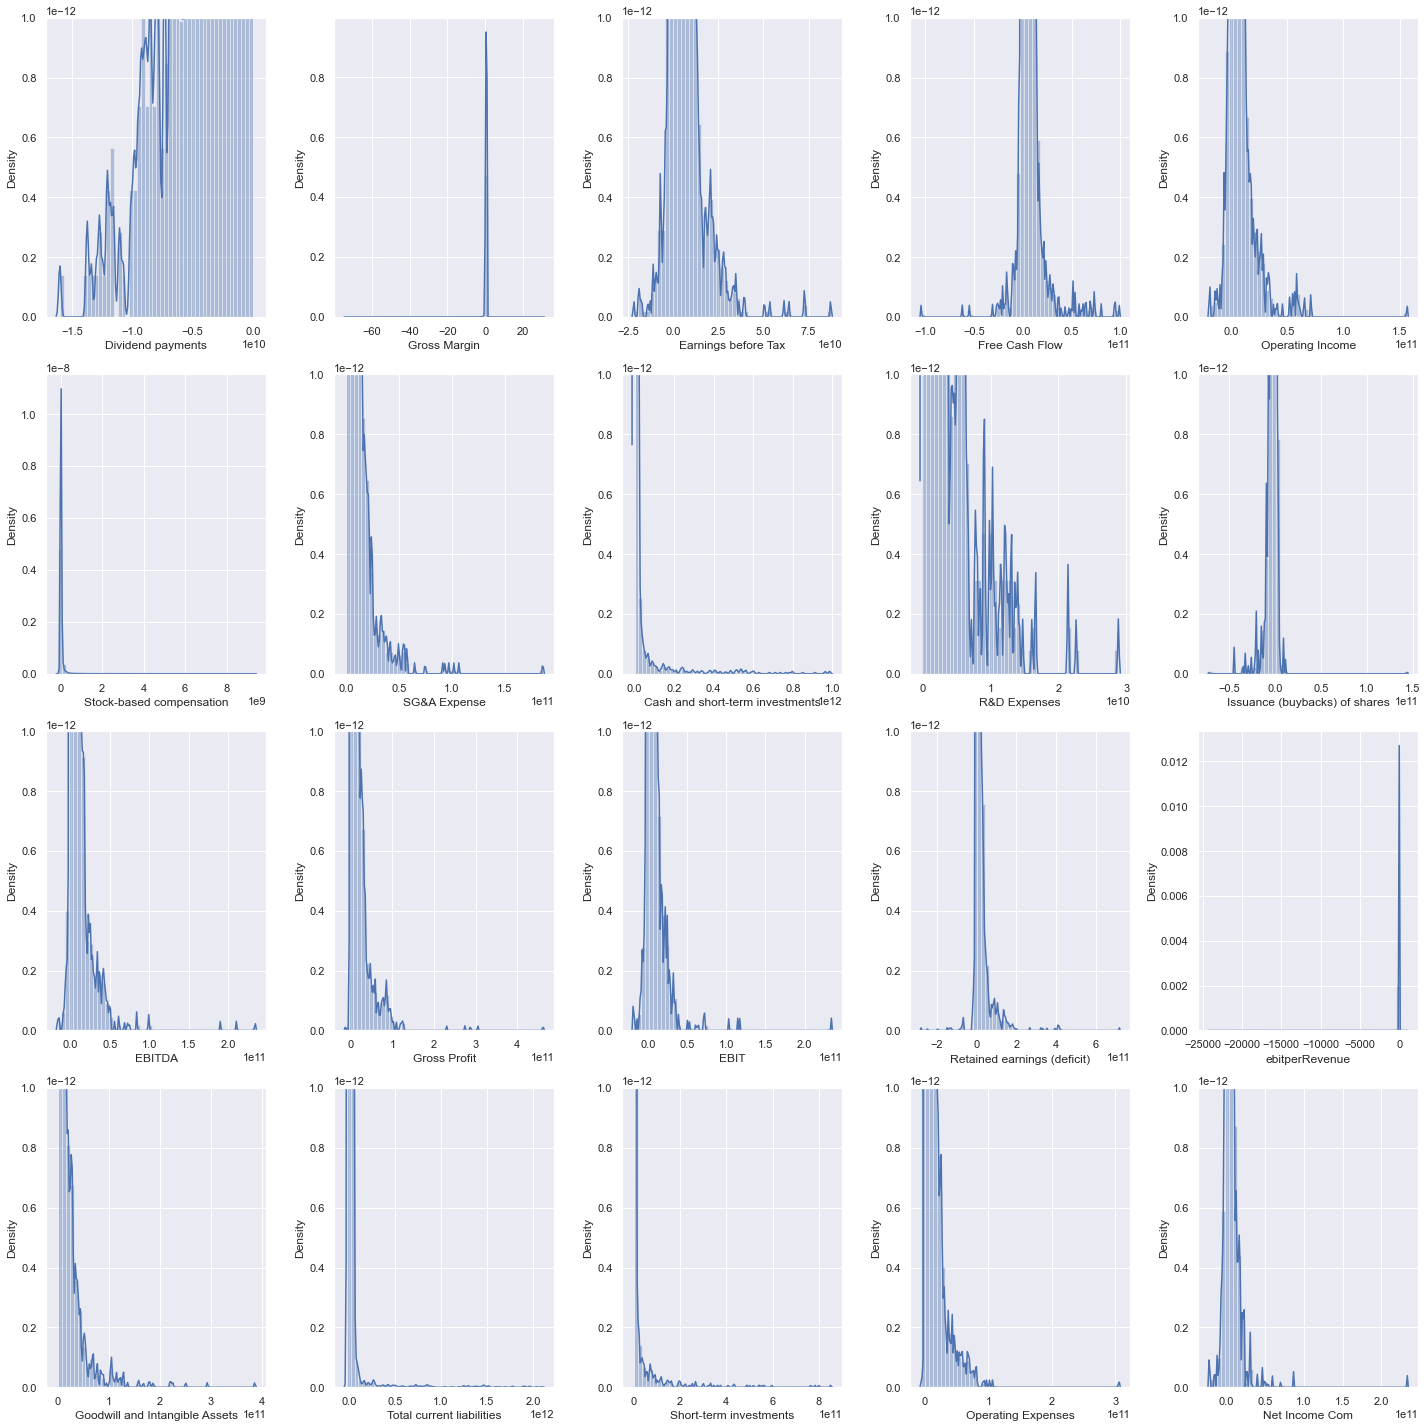

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_theme()

f, axes = plt.subplots(4, 5, figsize=(20, 20))

columnNames=attributeTop20.columns.tolist()
for attribute in range(20):
    axes[math.floor(attribute/5),attribute%5].set(xlabel=columnNames[attribute])
    sns.distplot(attributeTop20[columnNames[attribute]],ax=axes[math.floor(attribute/5),attribute%5]).set(ylim=(0))
#plt.setp(axes, yticks=[])
plt.tight_layout()

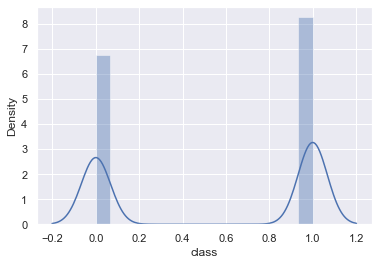

In [9]:
#Class
sns.distplot(attributeTop20["class"])

<h2>Scatter Plot Matrix 20x20</h2>

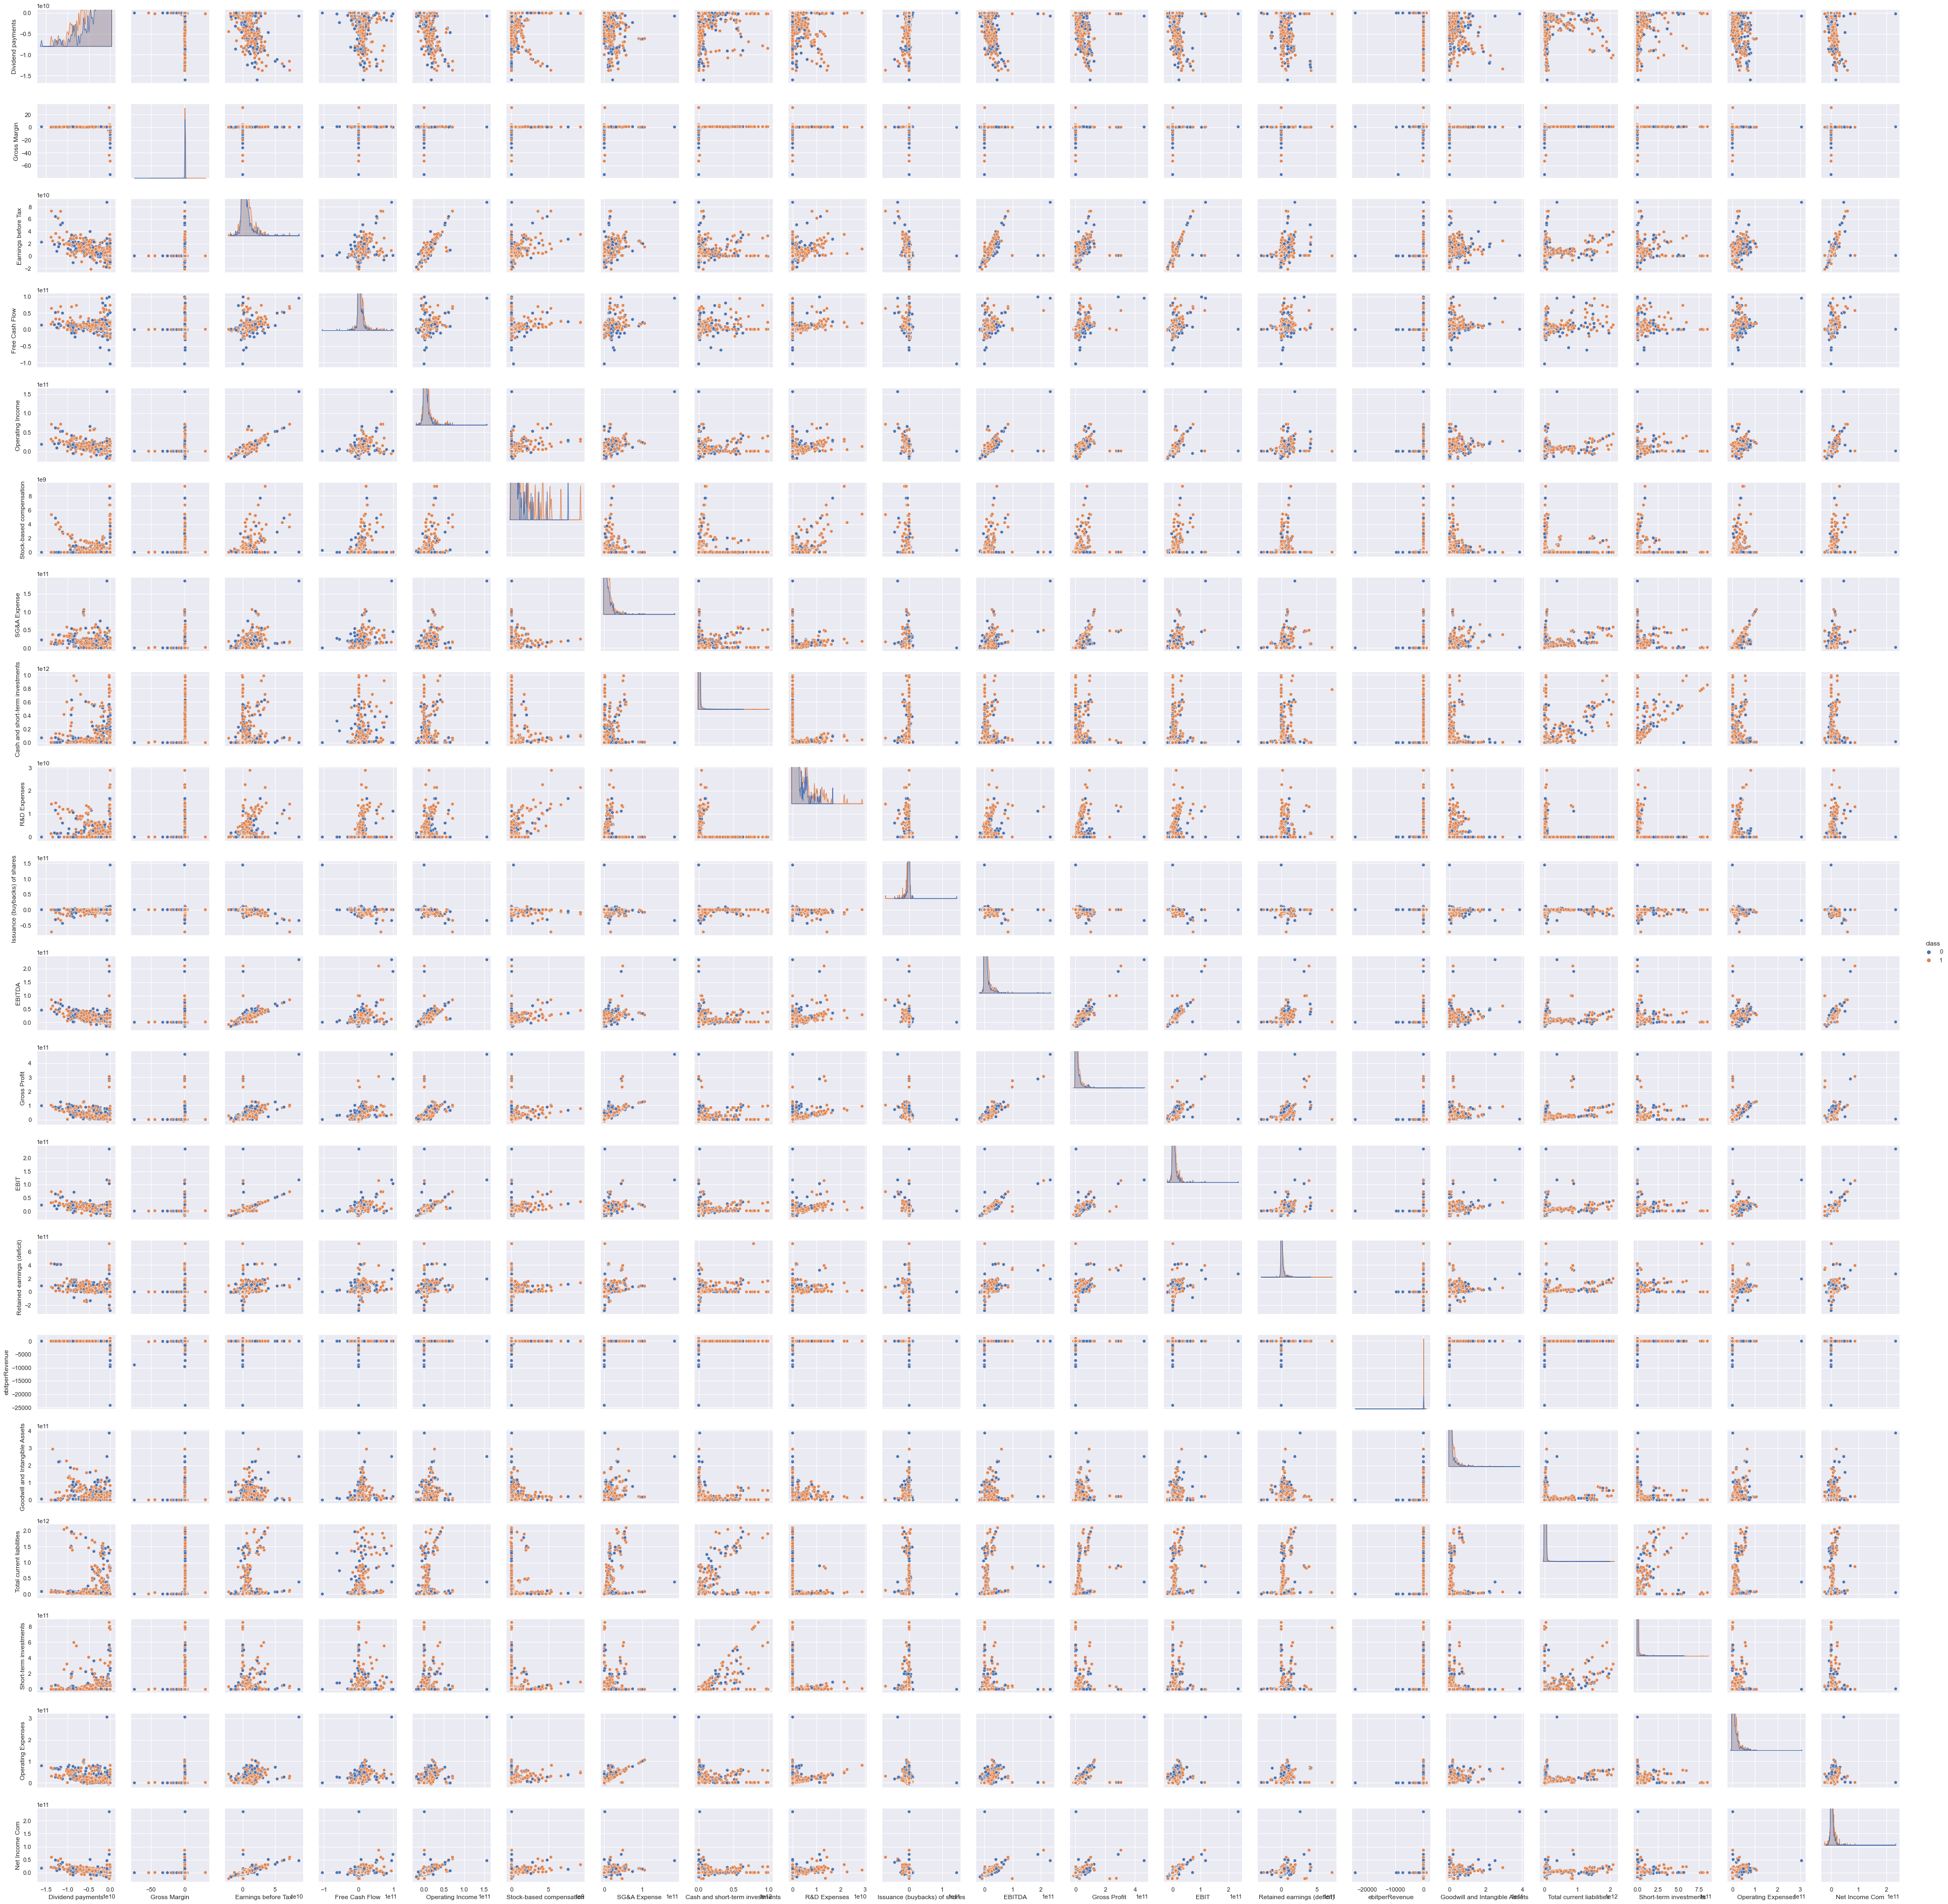

In [10]:
sns.pairplot(attributeTop20, hue='class')  
plt.show()